In [6]:
import torch
from torchvision import models
from torchvision import transforms as T

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

https://learnopencv.com/human-pose-estimation-using-keypoint-rcnn-in-pytorch/

In [4]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()
keypoints = ['nose','left_eye','right_eye',\
             'left_ear','right_ear','left_shoulder',\
             'right_shoulder','left_elbow','right_elbow',\
             'left_wrist','right_wrist','left_hip',\
             'right_hip','left_knee', 'right_knee', \
             'left_ankle','right_ankle']

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to C:\Users\keret/.cache\torch\hub\checkpoints\keypointrcnn_resnet50_fpn_coco-fc266e95.pth


In [9]:
img_path ="./data/yuko_suzuhana.jpg"
img = Image.open(img_path)
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
output = model([img_tensor])[0]

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    for person_id in range(len(all_keypoints)):
        if confs[person_id]>conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            for kp in range(len(scores)):
                if scores[kp]>keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                    cv2.circle(img_copy, keypoint, 5, color, -1)
    return img_copy

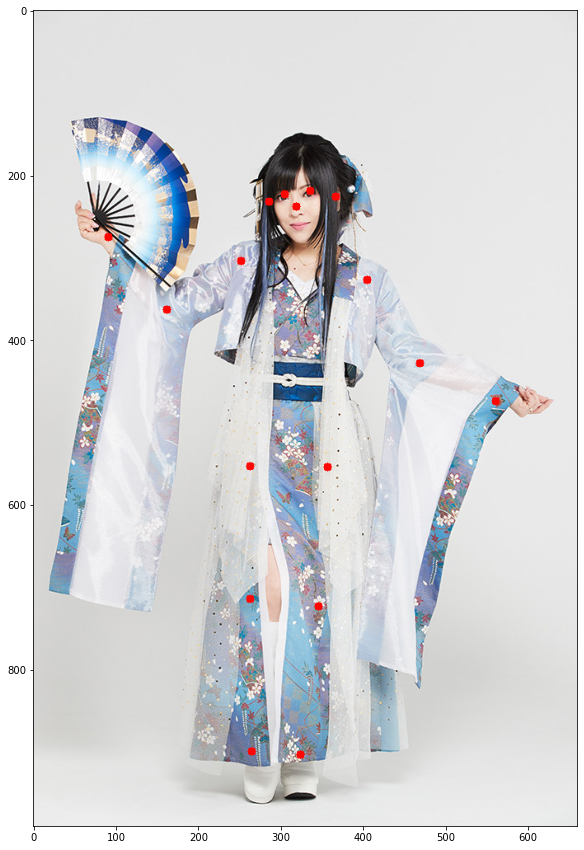

In [27]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"], keypoint_threshold=2)
plt.figure(figsize=(20,15))
plt.imshow(keypoints_img)

In [18]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
    ]
    return limbs

limbs = get_limbs_from_keypoints(keypoints)

In [29]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    if len(output["keypoints"])>0:
        colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
        for person_id in range(len(all_keypoints)):
            if confs[person_id]>conf_threshold:
                keypoints = all_keypoints[person_id, ...]
                for limb_id in range(len(limbs)):
                    limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
                    limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
                    limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
                    if limb_score> keypoint_threshold:
                        color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                        cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 2)
    return img_copy

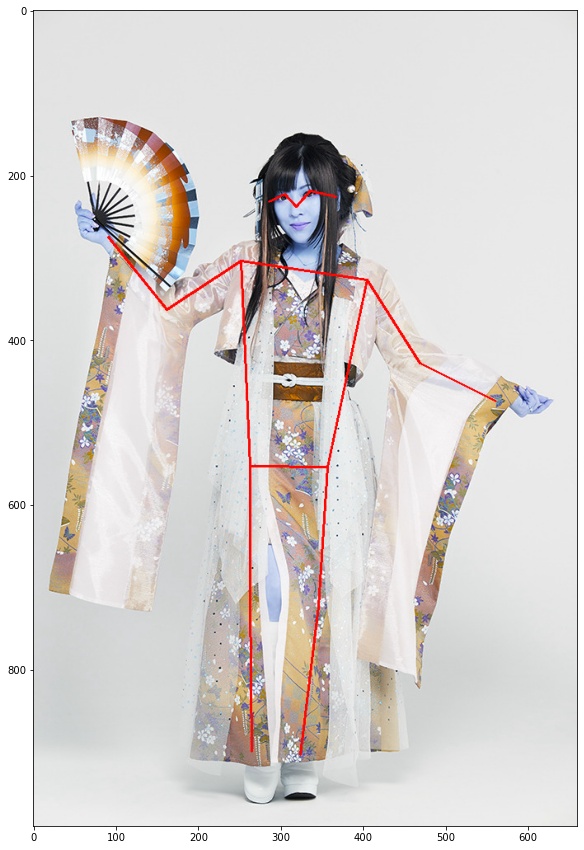

In [30]:
skeletal_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,15))
plt.imshow(skeletal_img)